###### 2023-11-23 ITHS

```
===============================

Lektion 2: Robert Nyquist

===============================
```


Usually same activation function throughout network, but output will differ.

Regression vs Classification
- Regression: Linear (Or ReLU to clip at 0)
- Simple Sigmoid or Softmax

More activation funcs
- Sigmoid (logistic) for binary classification
- Softmax, multi-class classification


### Loss functions

Performance metric. Corner stone for back propagation.


- MSE (L2 loss)
    - Most common for regression
    - Derivable

- MAE (L1 loss)
    - Less slopey :sunglasses:
    - Not derivable at 0

- Huber Loss 
- Binary Cross Entropy Loss
- Multi-Class Cross Entropy Loss

Init random weights with keras

Inference of network - forward pass:
Data (k) -> NN input node --> hidden layers --> output-activation function

---
---

### Training a NN on MNIST with Keras
[TensorFlow Resources](https://www.tensorflow.org/datasets/keras_example)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Loading MNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

type(ds_train), type(ds_test), type(ds_info)

2023-11-23 11:05:22.908284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensorflow.python.data.ops.prefetch_op._PrefetchDataset,
 tensorflow.python.data.ops.prefetch_op._PrefetchDataset,
 tensorflow_datasets.core.dataset_info.DatasetInfo)

In [2]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/helvetica/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

### Normalizing & Training Pipeline

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE) # Normalizing & CPU optimizing

ds_train = ds_train.cache() # if dataset fits into memory, improves speed significantly
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE) # automatically choose the optimal prefetch

Plotting training data as images

(128, 28, 28, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>


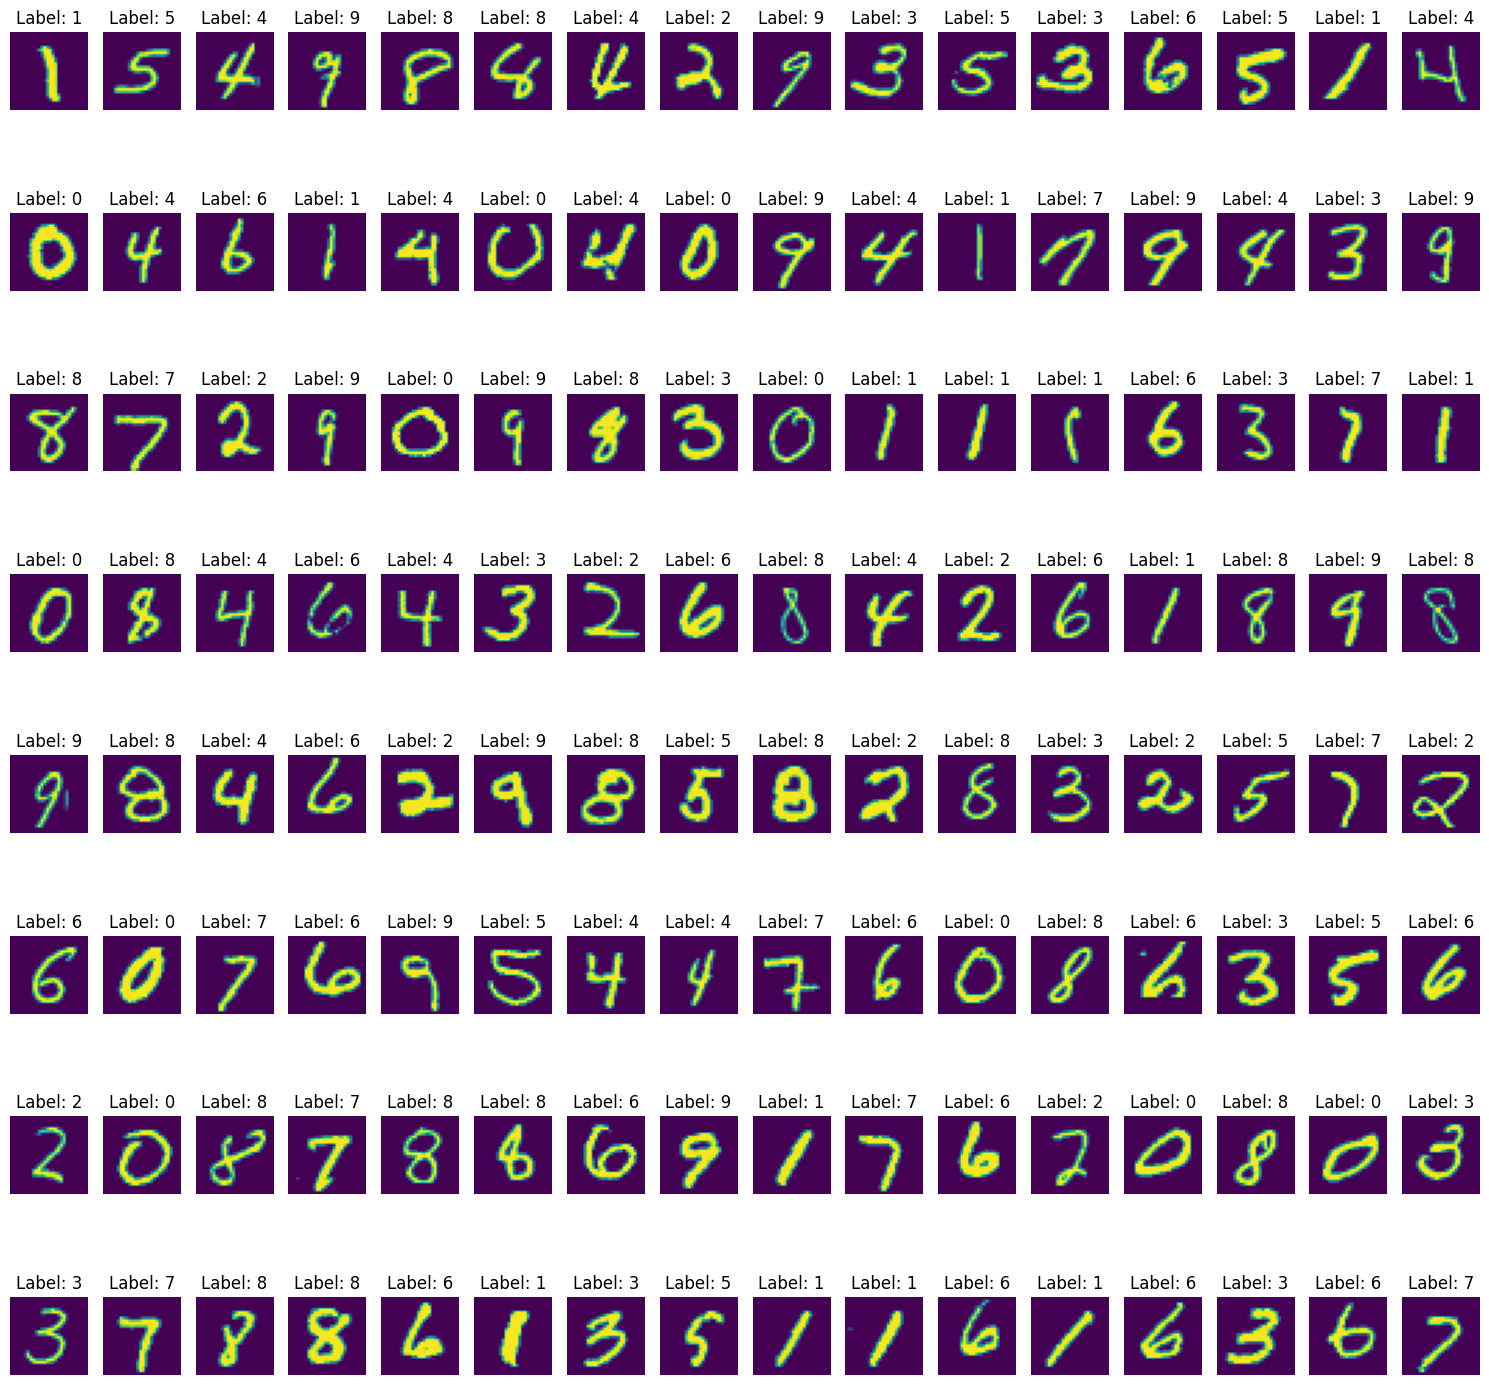

In [4]:
import matplotlib.pyplot as plt
for images, labels in ds_train.take(1):
    print(images.shape, type(images)) # tensor with shape (128, 28, 28, 1) b, h, w, and one color channel (grayscale)

    fig, axes = plt.subplots(8, 16, figsize=(15, 15))
    for i in range(images.shape[0]):
        image_np = images[i].numpy().squeeze()  # remove the single channel dimension

        row_idx = i // 16
        col_idx = i % 16
        axes[row_idx, col_idx].imshow(image_np)
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'Label: {labels[i].numpy()}')
    plt.tight_layout()
    plt.show()

### Eval Pipeline

In [5]:
# Similar to training pipeline, except no shuffle

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### Configure Model

[tf.keras.models.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

In [6]:
model = tf.keras.models.Sequential([

  # Transform the 2D array (28x28) into a 1D array of size 784
  tf.keras.layers.Flatten(input_shape=(28, 28)),

  # Dense (fully connected) with 128 perceptrons/neurons (or units)
  # Each unit perform a weighted sum of its inputs, apply ReLU and produce an output
  tf.keras.layers.Dense(128, activation='relu'),

  # Output layer, linear
  tf.keras.layers.Dense(10)

])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


[tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [8]:
model.compile(

    # Adam with learning rate 0.001
    optimizer=tf.keras.optimizers.Adam(0.001),

    # Loss & metrics: Sparse Categorical Accuracy
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

### Train Model

In [9]:
history = model.fit(
    ds_train,
    epochs=12,
    validation_data=ds_test,
)

Epoch 1/12


469/469 [==============================] - 2s 3ms/step - loss: 0.3548 - sparse_categorical_accuracy: 0.9018 - val_loss: 0.1844 - val_sparse_categorical_accuracy: 0.9474
Epoch 2/12
469/469 [==============================] - 1s 3ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9541 - val_loss: 0.1389 - val_sparse_categorical_accuracy: 0.9594
Epoch 3/12
469/469 [==============================] - 1s 2ms/step - loss: 0.1147 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.1142 - val_sparse_categorical_accuracy: 0.9640
Epoch 4/12
469/469 [==============================] - 1s 2ms/step - loss: 0.0886 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.0971 - val_sparse_categorical_accuracy: 0.9717
Epoch 5/12
469/469 [==============================] - 1s 2ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.0871 - val_sparse_categorical_accuracy: 0.9742
Epoch 6/12
469/469 [==============================] - 1s 2ms/step - loss: 0.0594 - sparse_categorical_accuracy:

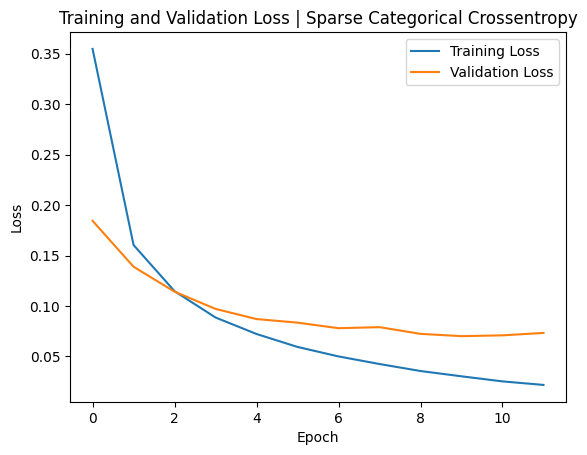

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss | Sparse Categorical Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

###  Test Model

In [25]:
eval_result = model.evaluate(ds_test)

print("Test Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])

 1/79 [..............................] - ETA: 0s - loss: 0.0328 - sparse_categorical_accuracy: 0.9844

79/79 [==============================] - 0s 2ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9788
Test Loss: 0.07332845777273178
Test Accuracy: 0.9787999987602234


In [26]:
for images, labels in ds_test:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    print("True:", labels.numpy())
    print("Pred:", predicted_labels.numpy())

    for i in range(len(predicted_labels)):
        if predicted_labels[i] != labels[i]:
            print(f"Failed on {i}: {predicted_labels[i]}, ground_truth = {labels[i]}")

print(failed_indices)

4/4 [==============================] - 0s 2ms/step
True: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3 8 7 5 4 2
 5 5 8 5 2 9 2 4 2 7 0 5 1 0 7 9 9 9 6 5 8 8 6 9 9 5 4 2 6 8 1 0 6 9 5 5 4
 1 6 7 5 2 9 0 6 4 4 2 8 7 8 3 0 9 0 1 1 9 4 5 9 7 6 6 0 7 7 8 4 8 8 1 8 0
 2 9 1 0 3 9 7 0 4 9 6 8 9 3 5 4 3]
Pred: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 0 3 8 2 5 4 2
 5 5 8 5 2 9 2 4 2 7 0 5 1 0 7 9 9 9 6 5 8 8 6 9 9 5 4 2 6 8 1 0 6 9 5 5 4
 1 6 7 5 2 9 0 6 4 4 2 8 7 8 3 0 9 0 1 1 9 4 5 9 7 6 6 0 7 7 8 4 8 8 1 8 0
 2 9 1 0 3 9 7 0 4 9 6 8 9 3 5 4 3]
Failed on 30: 0, ground_truth = 9
Failed on 33: 2, ground_truth = 7
4/4 [==============================] - 0s 2ms/step
True: [2 2 4 0 3 2 3 5 1 1 2 4 8 2 2 6 8 6 1 7 0 6 1 7 7 3 4 4 6 9 0 8 2 8 6 0 9
 7 8 2 9 0 2 3 2 8 7 0 1 7 8 5 1 2 3 1 9 8 7 9 0 8 3 9 3 9 7 4 9 3 1 2 2 6
 0 7 6 9 5 9 7 4 2 0 1 0 4 9 9 1 9 2 2 6 5 6 0 0 2 7 7 4 7 5 1 7 7 8 2 5 9
 6 6 8 0 1 2 1 7 7 7 3 0 3 4 8 3 6]
Pred: [2 2 4 0 3 2 3 5 1 1 2 

Overall good results.